In [1]:
!git clone https://github.com/Maoabear/IEEE_TGRS_GCN

Cloning into 'IEEE_TGRS_GCN'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 298 (delta 49), reused 59 (delta 45), pack-reused 225
Receiving objects: 100% (298/298), 87.88 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Updating files: 100% (44/44), done.


here we go
epoch 0: Train_loss: 2.384664, Val_loss: 2.686999, Train_acc: 0.293602, Val_acc: 0.082508
epoch 50: Train_loss: 1.076202, Val_loss: 1.162122, Train_acc: 0.698123, Val_acc: 0.605198
epoch 100: Train_loss: 0.843381, Val_loss: 1.010459, Train_acc: 0.758584, Val_acc: 0.662954
epoch 150: Train_loss: 0.644909, Val_loss: 0.953892, Train_acc: 0.827322, Val_acc: 0.722360
epoch 200: Train_loss: 0.577119, Val_loss: 1.233898, Train_acc: 0.833869, Val_acc: 0.585190


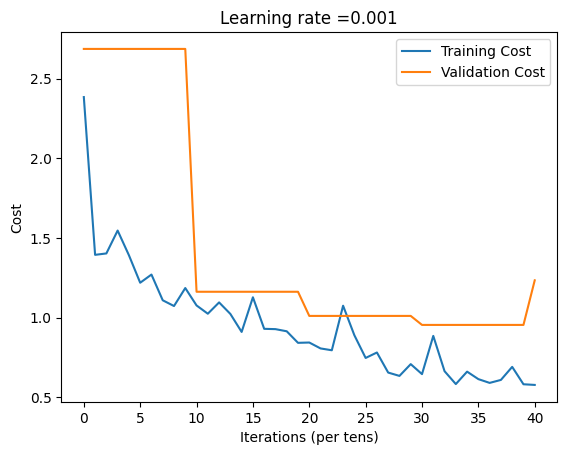

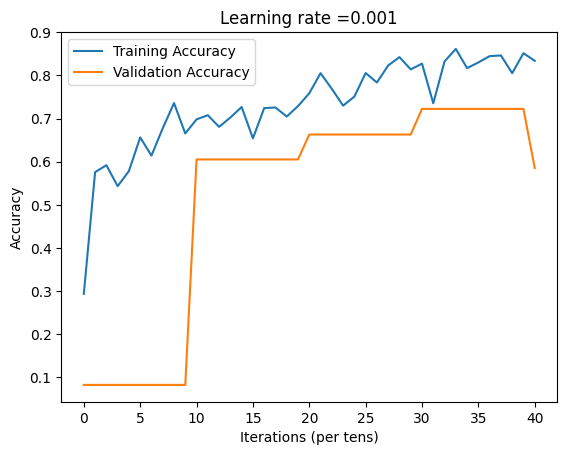

Parameters have been trained!


NameError: name 'features' is not defined

In [5]:
"""
@author: danfeng
"""
#import library
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as scio
import scipy.io as sio
from torch.utils.data import DataLoader, TensorDataset

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

class GCN(nn.Module):
    def __init__(self, n_x, n_y):
        super(GCN, self).__init__()
        self.fc1 = nn.Linear(n_x, 128)
        self.fc2 = nn.Linear(128, 16)
        self.batch_norm1 = nn.BatchNorm1d(n_x)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(16)

    def forward(self, x, L, is_training):
        x = self.batch_norm1(x)
        x = torch.relu(torch.matmul(L.T, self.fc1(x)))
        x = self.batch_norm2(x)
        x = torch.relu(torch.matmul(L, self.fc2(x)))
        x = self.batch_norm3(x)
        return x

def mynetwork_optimaization(model, criterion, reg, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    return criterion, optimizer

def network_accuracy(y_pred, y_true):
    correct_prediction = torch.argmax(y_pred, dim=1) == torch.argmax(y_true, dim=1)
    accuracy = torch.mean(correct_prediction.float())
    return accuracy.item()

def train_mynetwork(x_train, x_test, y_train, y_test, L_train, L_test, learning_rate_base=0.001, beta_reg=0.001, num_epochs=200, minibatch_size=32, print_cost=True):

    seed = 1
    torch.manual_seed(seed)

    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32),
                                  torch.tensor(L_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)

    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.float32),
                                 torch.tensor(L_test, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape

    model = GCN(n_x, n_y)
    criterion = nn.CrossEntropyLoss()
    criterion, optimizer = mynetwork_optimaization(model, criterion, beta_reg, learning_rate_base)

    costs = []
    costs_dev = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs + 1):
        epoch_cost = 0.
        epoch_acc = 0.

        model.train()
        for batch_x, batch_y, batch_l in train_loader:
            optimizer.zero_grad()
            batch_l = batch_l.squeeze(0)
            outputs = model(batch_x, batch_l, True)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_cost += loss.item()
            epoch_acc += network_accuracy(outputs, batch_y)

        epoch_cost_train = epoch_cost / len(train_loader)
        epoch_acc_train = epoch_acc / len(train_loader)

        if print_cost and epoch % 50 == 0:
            model.eval()
            epoch_cost_test = 0.
            epoch_acc_test = 0.
            with torch.no_grad():
                for batch_x, batch_y, batch_l in test_loader:
                    batch_l = batch_l.squeeze(0)
                    outputs = model(batch_x, batch_l, False)
                    loss = criterion(outputs, batch_y)
                    epoch_cost_test += loss.item()
                    epoch_acc_test += network_accuracy(outputs, batch_y)
            epoch_cost_test /= len(test_loader)
            epoch_acc_test /= len(test_loader)
            print(f"epoch {epoch}: Train_loss: {epoch_cost_train:.6f}, Val_loss: {epoch_cost_test:.6f}, Train_acc: {epoch_acc_train:.6f}, Val_acc: {epoch_acc_test:.6f}")

        if print_cost and epoch % 5 == 0:
            costs.append(epoch_cost_train)
            train_acc.append(epoch_acc_train)
            costs_dev.append(epoch_cost_test)
            val_acc.append(epoch_acc_test)

    # 绘制cost图像
    plt.plot(np.squeeze(costs), label='Training Cost')
    plt.plot(np.squeeze(costs_dev), label='Validation Cost')
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate_base))
    plt.legend()
    plt.show()

    # 绘制accuracy图像
    plt.plot(np.squeeze(train_acc), label='Training Accuracy')
    plt.plot(np.squeeze(val_acc), label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate_base))
    plt.legend()
    plt.show()


    # lets save the parameters in a variable
    parameters = {name: param.detach().numpy() for name, param in model.named_parameters()}
    print("Parameters have been trained!")

    return parameters, val_acc, features

print("here we go")
Train_X = scio.loadmat('/content/IEEE_TGRS_GCN/HSI_GCN/Train_X.mat')
TrLabel = scio.loadmat('/content/IEEE_TGRS_GCN/HSI_GCN/TrLabel.mat')
Test_X = scio.loadmat('IEEE_TGRS_GCN/HSI_GCN/Test_X.mat')
TeLabel = scio.loadmat('IEEE_TGRS_GCN/HSI_GCN/TeLabel.mat')
Train_L = scio.loadmat('IEEE_TGRS_GCN/HSI_GCN/Train_L.mat')
Test_L = scio.loadmat('IEEE_TGRS_GCN/HSI_GCN/Test_L.mat')


Train_X = Train_X['Train_X']
Test_X = Test_X['Test_X']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Train_L = Train_L['Train_L']
Test_L = Test_L['Test_L']

TrLabel = convert_to_one_hot(TrLabel-1, 16)
TrLabel = TrLabel.T
TeLabel = convert_to_one_hot(TeLabel-1, 16)
TeLabel = TeLabel.T

parameters, val_acc, features = train_mynetwork(Train_X, Test_X, TrLabel, TeLabel, Train_L, Test_L)
sio.savemat('features.mat', {'features': features})
